## Golden Cross & Death Cross Strategy
_Roshan Mahes (based on Larry Kubin's tutorial)._

This strategy is explained and implemented by Larry Kubin in the following tutorial:

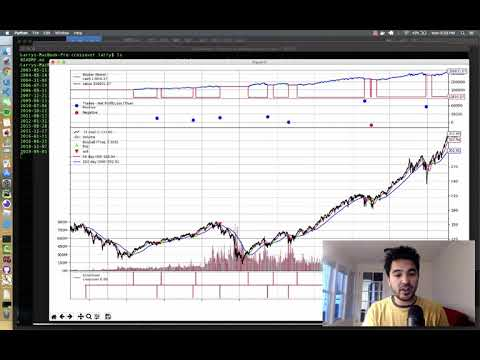

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('bbKTYelmfR4')

The _Golden Cross (Breakout) strategy_ is a moving average-based technical indicator proposed by Ken Calhoun in 2017. Recall that _bullish signals_ is characterized by rising stock prices, whereas _bearish signals_ are characterized by dropping stock prices. The _golden cross_ is a candlestick pattern that is a bullish signal in which a (relatively) short-term moving average crosses over a long-term moving average. Specifically, this often refers to the 50-day moving average crossing over the 200-day moving average. As long-term indicators carry more weight, the golden cross indicates a bull market on the horizon and is reinforced by high trading volumes.

Let's install some necessary packages:

In [2]:
%pip install yfinance
%pip install backtrader

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


To implement this strategy, we import the following packages:

In [3]:
import math
from datetime import datetime

import yfinance as yf # pricing data
import backtrader as bt # backtesting library

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9.5, 5]
plt.rcParams['figure.dpi'] = 100

In this tutorial, we implement our strategy on the SPY ETF, which tracks the S&P 500 index. Let's download the data:

In [4]:
SPY_prices = yf.download('SPY', end='2020-02-01')
SPY_prices.to_csv('data/SPY.csv')
SPY_prices

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,26.184059,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,26.370279,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,26.426161,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,26.705482,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,26.817228,531500
...,...,...,...,...,...,...
2020-01-27,323.029999,325.119995,322.660004,323.500000,320.199799,84062500
2020-01-28,325.059998,327.850006,323.600006,326.890015,323.555206,63834000
2020-01-29,328.380005,328.630005,326.399994,326.619995,323.287933,53888900


As we can see, the data starts from 1993, January 29. Hence, we've got almost 30 years of daily data!

Before we implement the strategy, we will show how our backtesting library `backtrader` works. _Cerebro_ is the cornerstone of `backtrader` as it serves as a central point for gathering all inputs and executing the backtesting. We initialize it using the command `bt.Cerebro()`. Next, we set our initial amount of money to \$100,000. We load in our SPY data, and execute `cerebro` using the command `cerebro.run()`. As we haven't implemented a strategy yet, our final cash value will still be \$100,000.

<IPython.core.display.Javascript object>


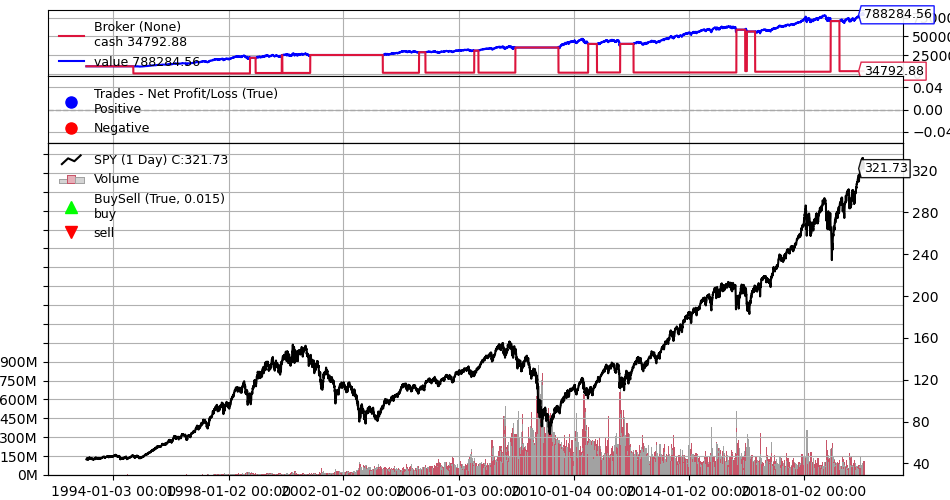

In [5]:
INITIAL_CASH = 100000

# initialize
cerebro = bt.Cerebro()
cerebro.broker.setcash(INITIAL_CASH)

# add data feed
feed = bt.feeds.PandasData(dataname=SPY_prices)
cerebro.adddata(feed, name='SPY')

# run cerebro
cerebro.run()
cerebro.plot();

Our strategy will be defined as a class `GoldenCross` that extends the `Strategy` method in the `backtrader` library.

In [6]:
class GoldenCross(bt.Strategy):
    """
    Implements the Golden Cross strategy.
    
    # Parameters:
    # short: length of short moving average (default: 50).
    # long: length of the long moving average (default: 200).
    # order_percentage: percentage of cash that we invest at any given time.
    # ticker: ticker symbol of the asset to trade on.
    """
    
    params = (('short', 50), ('long', 200), ('order_percentage', 0.95), ('ticker', 'SPY'))

    # define constructor
    def __init__(self):

        self.short_MA = bt.indicators.SMA(self.data.close, period=self.params.short, plotname='50-day MA')
        self.long_MA = bt.indicators.SMA(self.data.close, period=self.params.long, plotname='200-day MA')

        # returns 1.0 (resp. -1.0) if short_MA crosses long_MA upwards (resp. downwards) 
        self.crossover = bt.indicators.CrossOver(self.short_MA, self.long_MA)

    # check whether or not to make a trade
    def next(self):
        date = datetime.fromordinal(int(self.data.datetime[0])).strftime('%Y-%m-%d')
        
        # golden cross (buy shares)
        if self.position.size == 0 and self.crossover == 1:
                amount_to_invest = self.params.order_percentage * self.broker.cash
                self.size = math.floor(amount_to_invest / self.data.close) # round down number of shares to buy

                print(f'{date}: Buy {self.size} shares of {self.params.ticker} at {self.data.close[0]:.2f}.')
                self.buy(size=self.size)
        
        # death cross (close position)
        if self.position.size > 0 and self.crossover == -1:
                print(f'{date}: Sell {self.size} shares of {self.params.ticker} at {self.data.close[0]:.2f}.\n')
                self.close()


Now let's check how well our strategy works.

1994-09-14: Buy 2019 shares of SPY at 47.05.
1998-09-29: Sell 2019 shares of SPY at 104.94.

1998-12-08: Buy 1714 shares of SPY at 118.41.
1999-11-04: Sell 1714 shares of SPY at 136.53.

1999-11-11: Buy 1700 shares of SPY at 138.50.
2000-10-30: Sell 1700 shares of SPY at 140.53.

2003-05-15: Buy 2506 shares of SPY at 95.11.
2004-08-18: Sell 2506 shares of SPY at 110.03.

2004-11-05: Buy 2335 shares of SPY at 117.28.
2006-07-19: Sell 2335 shares of SPY at 125.69.

2006-09-11: Buy 2255 shares of SPY at 130.41.
2007-12-21: Sell 2255 shares of SPY at 148.13.

2009-06-23: Buy 3729 shares of SPY at 89.35.
2010-07-06: Sell 3729 shares of SPY at 102.87.

2010-10-22: Buy 3204 shares of SPY at 118.35.
2011-08-12: Sell 3204 shares of SPY at 118.12.

2012-01-31: Buy 2888 shares of SPY at 131.32.
2015-08-28: Sell 2888 shares of SPY at 199.28.

2015-12-17: Buy 2733 shares of SPY at 204.86.
2016-01-11: Sell 2733 shares of SPY at 192.11.

2016-04-25: Buy 2572 shares of SPY at 208.61.
2018-12-07: Sell 

<IPython.core.display.Javascript object>


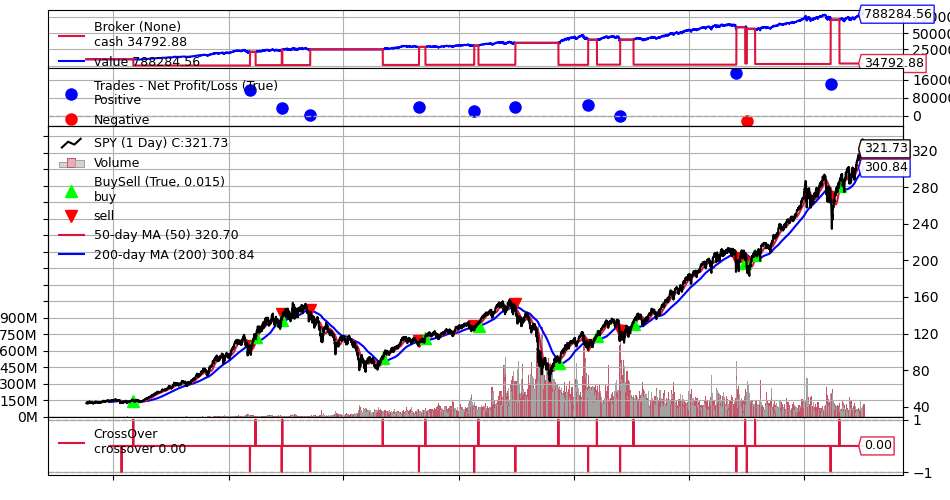

In [7]:
# add strategy
cerebro.addstrategy(GoldenCross)

# run cerebro
cerebro.run()
cerebro.plot();

As we can see, most of the times we sell our shares for a higher price than we bought it for. However, in some situations this strategy turns out to have downsides as well. Using the `backtrader_plotting` library, we can even produce nicer plots:

In [10]:
%pip install backtrader_plotting

In [11]:
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo

b = Bokeh(style='bar', plot_mode='single', scheme=Tradimo())
cerebro.plot(b);

TypeError: <class '__main__.GoldenCross'> is a built-in class